In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils


In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, captions):
        emb = self.embedding(captions)
        out, _ = self.lstm(emb)
        return out  # B x seq_len x (2*hidden_dim)


In [ ]:


class AttentionalGenerator(nn.Module):
    def __init__(self, z_dim, text_dim, base_channels=64):
        super().__init__()
        self.fc = nn.Linear(z_dim, base_channels * 8 * 4 * 4)
        self.cross_attn = CrossAttention(base_channels * 8, text_dim)
        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(True),
            SelfAttention(base_channels * 4),
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(base_channels * 2, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, text_embeds):
        x = self.fc(z).view(-1, 512, 4, 4)
        B, C, H, W = x.shape
        img_feats = x.view(B, C, H * W).permute(0, 2, 1)
        img_feats = self.cross_attn(img_feats, text_embeds)
        x = img_feats.permute(0, 2, 1).view(B, C, H, W)
        return self.deconv_blocks(x)


class AttentionalDiscriminator(nn.Module):
    def __init__(self, text_dim, base_channels=64):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, base_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(base_channels),
            nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(base_channels * 2 * 16 * 16 + text_dim, 1)

    def forward(self, img, text_embeds):
        x = self.conv_blocks(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, text_embeds.mean(dim=1)], dim=1)
        return self.fc(x)


In [ ]:
def gan_loss(pred, target_is_real=True):
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return F.binary_cross_entropy_with_logits(pred, target)

z_dim = 100
G = AttentionalGenerator(z_dim=z_dim, text_dim=1024)
D = AttentionalDiscriminator(text_dim=1024)
text_encoder = TextEncoder(vocab_size=10000)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ------------------------------
#  Cross-Attention Block
# ------------------------------
class CrossAttention(nn.Module):
    """
    Cross-attention between image feature maps and text embeddings.
    Helps the generator align visual regions with semantic tokens.
    """
    def __init__(self, img_dim, text_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(img_dim, img_dim // 8, 1)
        self.key_linear = nn.Linear(text_dim, img_dim // 8)
        self.value_linear = nn.Linear(text_dim, img_dim)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, img_feat, text_embed):
        """
        img_feat: (B, C, H, W)
        text_embed: (B, text_dim)
        """
        B, C, H, W = img_feat.size()
        # Compute queries from image features
        query = self.query_conv(img_feat).view(B, -1, H * W).permute(0, 2, 1)  # (B, HW, C/8)
        # Compute keys and values from text embeddings
        key = self.key_linear(text_embed).unsqueeze(1)  # (B, 1, C/8)
        value = self.value_linear(text_embed).unsqueeze(2)  # (B, C, 1)

        # Attention map between image regions and text embedding
        attn = torch.bmm(query, key.transpose(1, 2))  # (B, HW, 1)
        attn = F.softmax(attn, dim=1)

        # Weighted combination of value across image positions
        out = value @ attn.permute(0, 2, 1)  # (B, C, HW)
        out = out.view(B, C, H, W)
        out = self.gamma * out + img_feat  # residual connection
        return out


# ------------------------------
#  Conditional Generator
# ------------------------------
class Generator(nn.Module):
    def __init__(self, embedding_dim=512, noise_dim=100, img_size=64):
        super().__init__()
        self.input_dim = embedding_dim + noise_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True)
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        self.cross_attn = CrossAttention(img_dim=128, text_dim=embedding_dim)

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        # ✅ Extra layer to reach 64x64 output
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.output_layer = nn.Sequential(
            nn.Conv2d(32, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, embedding):
        x = torch.cat((z, embedding), dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, 8, 8)
        x = self.deconv1(x)
        x = self.cross_attn(x, embedding)
        x = self.deconv2(x)
        x = self.deconv3(x)   # new layer
        x = self.output_layer(x)
        return x


Output image tensor shape: torch.Size([4, 3, 64, 64])


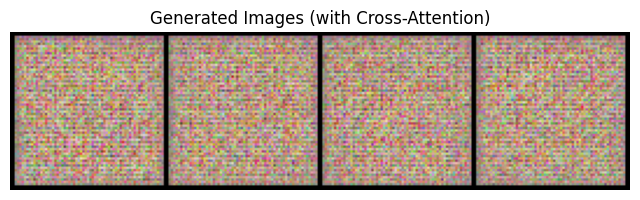

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Visualize generated images
def show_images(images, nrow=4):
    # Detach from GPU if needed and rescale from [-1, 1] → [0, 1]
    imgs = (images.detach().cpu() + 1) / 2
    grid = vutils.make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images (with Cross-Attention)")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()


# Example usage (continuing from your last code)
if __name__ == "__main__":
    noise_dim = 100
    embed_dim = 512
    batch_size = 4

    G = Generator(embedding_dim=embed_dim, noise_dim=noise_dim, img_size=64)
    z = torch.randn(batch_size, noise_dim)
    text_embed = torch.randn(batch_size, embed_dim)

    fake_imgs = G(z, text_embed)
    print("Output image tensor shape:", fake_imgs.shape)

    # Show images
    show_images(fake_imgs)


In [ ]:
# ------------------------------
# Minimal Conditional GAN Training Loop
# ------------------------------
import torch.optim as optim

# Simple discriminator
class Discriminator(nn.Module):
    def __init__(self, embedding_dim=512, img_size=64):
        super().__init__()
        self.label_fc = nn.Linear(embedding_dim, img_size * img_size)
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # Added a convolution layer
            nn.BatchNorm2d(256), # Added batch norm
            nn.LeakyReLU(0.2, inplace=True), # Added activation
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1), # Adjusted linear layer input size
            nn.Sigmoid()
        )

    def forward(self, img, embedding):
        B = img.size(0)
        label_map = self.label_fc(embedding).view(B, 1, 64, 64)
        x = torch.cat((img, label_map), dim=1)
        return self.net(x)

# Initialize
G = Generator(embedding_dim=512, noise_dim=100, img_size=64)
D = Discriminator(embedding_dim=512, img_size=64)
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Dummy data (for testing)
real_imgs = torch.randn(8, 3, 64, 64)
embeddings = torch.randn(8, 512)
z = torch.randn(8, 100)

for epoch in range(5):
    # Train Discriminator
    opt_D.zero_grad()
    real_labels = torch.ones(8, 1)
    fake_labels = torch.zeros(8, 1)
    real_preds = D(real_imgs, embeddings)
    d_real_loss = criterion(real_preds, real_labels)

    fake_imgs = G(z, embeddings)
    fake_preds = D(fake_imgs.detach(), embeddings)
    d_fake_loss = criterion(fake_preds, fake_labels)

    d_loss = (d_real_loss + d_fake_loss) / 2
    d_loss.backward()
    opt_D.step()

    # Train Generator
    opt_G.zero_grad()
    fake_preds = D(fake_imgs, embeddings)
    g_loss = criterion(fake_preds, real_labels)
    g_loss.backward()
    opt_G.step()

    print(f"Epoch [{epoch+1}/5] | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

Epoch [1/5] | D loss: 0.7759 | G loss: 2.4825
Epoch [2/5] | D loss: 0.8842 | G loss: 2.4643
Epoch [3/5] | D loss: 0.6666 | G loss: 3.0940
Epoch [4/5] | D loss: 0.4490 | G loss: 3.3051
Epoch [5/5] | D loss: 0.3409 | G loss: 3.1294


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Generated: torch.Size([4, 3, 64, 64])


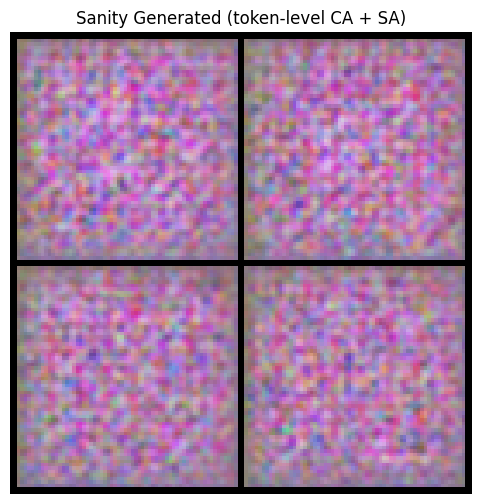

D output shape: torch.Size([4, 1])


In [ ]:
# ---------------------------
#  Install (Colab) - run once
# ---------------------------
# !pip install transformers ftfy regex tqdm
# (uncomment the line above in Colab and run)

# ---------------------------
#  Imports
# ---------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

# For CLIP tokenization & text encoder
from transformers import CLIPTokenizer, CLIPTextModel

# Small helper for visualization (optional)
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ---------------------------
#  Self-Attention (SAGAN-style)
# ---------------------------
class SelfAttention(nn.Module):
    """SAGAN-style self-attention for feature maps."""
    def __init__(self, in_channels):
        super().__init__()
        self.in_ch = in_channels
        self.f = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.g = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.h = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        f = self.f(x).view(B, -1, H*W)          # B x C' x N
        g = self.g(x).view(B, -1, H*W)          # B x C' x N
        h = self.h(x).view(B, -1, H*W)          # B x C  x N

        # compute attention (N x N)
        s = torch.bmm(f.permute(0, 2, 1), g)    # B x N x N
        beta = F.softmax(s, dim=-1)             # attention map
        o = torch.bmm(h, beta)                  # B x C x N
        o = o.view(B, C, H, W)
        return self.gamma * o + x

# ---------------------------
#  Cross-Attention (image patches attend to token embeddings)
# ---------------------------
class CrossAttention(nn.Module):
    """
    Token-level cross-attention:
      - Queries from image features (local patches)
      - Keys & Values from text token embeddings
    Shapes:
      img_feat: (B, C, H, W)
      text_tokens: (B, T, D_text)
    Output:
      (B, C, H, W)  -- residual added
    """
    def __init__(self, img_channels, text_dim, mid_dim=None):
        super().__init__()
        if mid_dim is None:
            mid_dim = max(img_channels // 8, 8)
        self.img_channels = img_channels
        self.text_dim = text_dim
        self.mid_dim = mid_dim

        # Q from image
        self.q_conv = nn.Conv2d(img_channels, mid_dim, kernel_size=1)
        # K, V from text tokens
        self.k_lin = nn.Linear(text_dim, mid_dim)
        self.v_lin = nn.Linear(text_dim, img_channels)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, img_feat, text_tokens, attn_mask=None):
        """
        img_feat: (B, C, H, W)
        text_tokens: (B, T, D_text)
        attn_mask: (B, T) boolean mask where True for real tokens (optional)
        """
        B, C, H, W = img_feat.shape
        N = H * W

        # Query: (B, N, mid_dim)
        q = self.q_conv(img_feat).view(B, self.mid_dim, N).permute(0, 2, 1)

        # Key: (B, T, mid_dim), Value: (B, T, C)
        k = self.k_lin(text_tokens)    # B x T x mid_dim
        v = self.v_lin(text_tokens)    # B x T x C

        # Attention scores: (B, N, T)
        attn_scores = torch.bmm(q, k.transpose(1, 2))  # (B, N, T)
        attn_scores = attn_scores / (self.mid_dim ** 0.5)

        if attn_mask is not None:
            # attn_mask: True for valid tokens -> we want to keep them,
            # so set masked positions to a large negative value
            mask = ~attn_mask.unsqueeze(1)  # (B, 1, T) True where padded
            attn_scores = attn_scores.masked_fill(mask, float('-1e9'))

        attn = F.softmax(attn_scores, dim=-1)  # (B, N, T)

        # Weighted sum over token values -> (B, N, C)
        out = torch.bmm(attn, v)               # (B, N, C)
        out = out.permute(0, 2, 1).view(B, C, H, W)  # (B, C, H, W)

        return self.gamma * out + img_feat

# ---------------------------
#  Attentional Generator (token-level CA + SA)
# ---------------------------
class AttnGenerator(nn.Module):
    def __init__(self, z_dim=100, token_dim=512, base_channels=64, img_size=64):
        """
        token_dim: dimensionality of CLIP token embeddings.
        z_dim: noise vector.
        base_channels: 64 -> controls network width.
        img_size: final image size (supports 64 here).
        """
        super().__init__()
        self.z_dim = z_dim
        self.token_dim = token_dim
        self.base = base_channels

        # Project noise to a small feature map (4x4)
        self.fc = nn.Linear(z_dim, (self.base * 8) * 4 * 4)

        # Upsample blocks (ConvTranspose2d)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(self.base * 8, self.base * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.base * 4),
            nn.ReLU(True)
        )
        # Cross-attention here (4->8 resolution): uses token embeddings
        self.cross_attn1 = CrossAttention(img_channels=self.base * 4, text_dim=token_dim)

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(self.base * 4, self.base * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.base * 2),
            nn.ReLU(True)
        )
        # Self-Attention at intermediate resolution
        self.self_attn = SelfAttention(self.base * 2)

        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(self.base * 2, self.base, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.base),
            nn.ReLU(True)
        )

        self.to_rgb = nn.Sequential(
            nn.Conv2d(self.base, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, token_embeddings, token_mask=None):
        """
        z: (B, z_dim)
        token_embeddings: (B, T, D_text) - CLIP token embeddings (last_hidden_state)
        token_mask: (B, T) boolean mask where True indicates valid tokens (optional)
        """
        B = z.size(0)
        x = self.fc(z).view(B, self.base * 8, 4, 4)

        x = self.up1(x)                              # -> (B, base*4, 8, 8)
        x = self.cross_attn1(x, token_embeddings, token_mask)

        x = self.up2(x)                              # -> (B, base*2, 16, 16)
        x = self.self_attn(x)

        x = self.up3(x)                              # -> (B, base, 32, 32)  (for img_size=64 we may need extra upsample)
        # if img_size == 64, do one more upsample:
        if self.to_rgb is not None:
            # if our target is 64x64, perform a final upsample to 64x64
            if x.shape[-1] < 64:
                x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

        out = self.to_rgb(x)                         # (B, 3, 64, 64)
        return out

# ---------------------------
#  Simple Conditional Discriminator
# ---------------------------
class AttnDiscriminator(nn.Module):
    """
    Conditional discriminator: concatenates a spatial label map
    obtained from the mean-pooled token embedding, then classifies.
    """
    def __init__(self, token_dim=512, base_channels=64, img_size=64):
        super().__init__()
        self.base = base_channels
        self.img_size = img_size

        # We'll concate 1-channel label map -> input channels = 3 + 1 = 4
        self.label_fc = nn.Linear(token_dim, img_size * img_size)

        self.net = nn.Sequential(
            nn.Conv2d(4, self.base, 4, 2, 1),     # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.base, self.base*2, 4, 2, 1), # 32 -> 16
            nn.BatchNorm2d(self.base*2),
            nn.LeakyReLU(0.2, inplace=True),

            SelfAttention(self.base*2),

            nn.Conv2d(self.base*2, self.base*4, 4, 2, 1), # 16 ->8
            nn.BatchNorm2d(self.base*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear((self.base*4) * (img_size // 8) * (img_size // 8), 1),
            nn.Sigmoid()
        )

    def forward(self, img, token_embeddings):
        # token_embeddings: (B, T, D) -> mean pool to get sentence vector
        sent = token_embeddings.mean(dim=1)          # (B, D)
        B = img.size(0)
        label_map = self.label_fc(sent).view(B, 1, self.img_size, self.img_size)
        x = torch.cat([img, label_map], dim=1)      # B x 4 x H x W
        return self.net(x)

# ---------------------------
#  CLIP helper: get token-level embeddings
# ---------------------------
class CLIPTextEncodingWrapper:
    """
    Utility wrapper to get token-level embeddings and masks from CLIP.
    Uses Hugging Face transformers' CLIPTokenizer + CLIPTextModel.
    """
    def __init__(self, model_name="openai/clip-vit-base-patch32", device=None):
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.model = CLIPTextModel.from_pretrained(model_name)
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    @torch.no_grad()
    def encode(self, texts):
        """
        texts: list[str] of length B
        returns:
          token_embeddings: (B, T, D)
          attention_mask: (B, T) boolean (True where token exists)
        """
        encoded = self.tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state: (B, T, D)
        token_embeds = outputs.last_hidden_state
        return token_embeds, attention_mask.bool()

# ---------------------------
#  Visualization helper
# ---------------------------
def show_images(images, nrow=4, title="Generated"):
    imgs = (images.detach().cpu() + 1) / 2.0  # assume tanh output [-1,1]
    grid = vutils.make_grid(imgs.clamp(0,1), nrow=nrow)
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0))
    plt.title(title)
    plt.show()

# ---------------------------
#  Minimal test run (sanity)
# ---------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate CLIP wrapper
    clip = CLIPTextEncodingWrapper(device=device)

    # Sample texts and encode tokens
    texts = ["a red bird with black wings", "a blue car on a road", "a bowl of fresh fruit", "a cat sitting on a couch"]
    token_embeds, token_mask = clip.encode(texts)   # B x T x D, B x T (bool)

    # Models
    z_dim = 100
    G = AttnGenerator(z_dim=z_dim, token_dim=token_embeds.size(-1), base_channels=64, img_size=64).to(device)
    D = AttnDiscriminator(token_dim=token_embeds.size(-1), base_channels=64, img_size=64).to(device)

    # Random noise
    B = len(texts)
    z = torch.randn(B, z_dim).to(device)
    token_embeds = token_embeds.to(device)
    token_mask = token_mask.to(device)

    # Generate
    fake = G(z, token_embeds, token_mask)   # (B, 3, 64, 64)
    print("Generated:", fake.shape)
    show_images(fake, nrow=2, title="Sanity Generated (token-level CA + SA)")

    # Discriminator forward (sanity)
    d_out = D(fake, token_embeds)
    print("D output shape:", d_out.shape)
